In [3]:
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests
import numpy as np
import pandas as pd
import json
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import rcParams

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sb

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [4]:
dbname = 'tutor_db'
username = 'codonnell'
pswd = '7883511'

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM tutor_main
"""
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,qual_2,qual_3,sunday_hours,monday_hours,tuesday_hours,wednesday_hours,thursday_hours,friday_hours,saturday_hours,mean_hours
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,Masters,{},0.583333,0.416667,0.583333,0.375000,0.375000,0.583333,0.583333,0.500000
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,Masters,{},0.500000,0.541667,0.583333,0.583333,0.583333,0.500000,0.333333,0.517857
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,{},{},1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,Masters,{},0.000000,0.375000,0.541667,0.541667,0.250000,0.416667,0.375000,0.357143
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,{},{},0.041667,0.166667,0.083333,0.125000,0.125000,0.083333,0.000000,0.089286


In [5]:
sql_query = """
SELECT * FROM tutor_subjects
"""
tutor_subjects = pd.read_sql_query(sql_query,con)
tutor_subjects.head()

,index,tutor_ids,subjects
0,0,7269032,Precalculus
1,1,7269032,French
2,2,7269032,European History
3,3,7269032,Calculus
4,4,7269032,Spanish


In [51]:
def subj_len(subj):
    return len(subj.split(' '))

In [53]:
tutor_subjects['subjects_len']=tutor_subjects['subjects'].apply(subj_len)
tutor_subjects['subjects_len'].value_counts()

1    104064
2     74390
3      1336
4       658
Name: subjects_len, dtype: int64

In [6]:
tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(lambda x: ' '.join(x)).reset_index()
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(float)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)

In [7]:
tutors_joined.head()

,tutor_ids,subjects
0,10504,ESL/ESOL Computer Science Spanish General Comp...
1,10675,Organic Chemistry Precalculus Prealgebra Chemi...
2,10843,Writing Special Needs Dyslexia Spelling Phonic...
3,10886,Elementary Math GRE Logic ACT Science ACT Math...
4,10949,Criminal Justice C++ C Visual Basic Java Compu...


In [43]:
stopWords = [] 

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords,
    ngram_range = (1,2)
)
tfidf.fit(tutors_joined['subjects'])
text = tfidf.transform(tutors_joined['subjects'])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


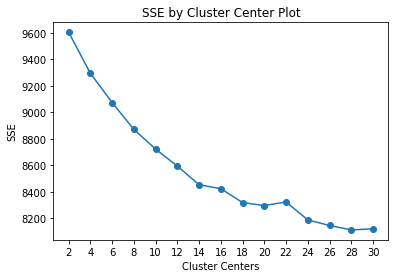

In [44]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 30)

In [45]:
kmeans = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20)
clusters = kmeans.fit_predict(text)

In [133]:
centroids = kmeans.cluster_centers_

In [134]:
centroids

array([[7.34512134e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.00909118e-04, 0.00000000e+00, 1.83270716e-04, ...,
        0.00000000e+00, 5.69505314e-04, 3.18262025e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.95151777e-04, 1.42245987e-04, 3.37789512e-04, ...,
        4.39547503e-04, 6.13114255e-04, 1.26228319e-03],
       [2.95593804e-04, 1.14157970e-04, 0.00000000e+00, ...,
        8.31816291e-04, 2.62768178e-04, 2.35242027e-04]])

In [135]:
test_vec = ['Math Algebra Physics Spanish Excel Homeschooling']
diff =  centroids - np.array(tfidf.transform(test_vec).todense())
#for cent in centroids:
minval = min([np.linalg.norm(d) for d in diff])
minval

0.9689214208756889

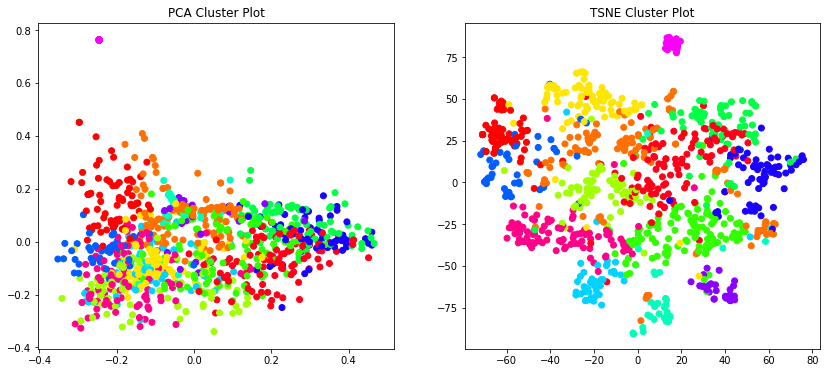

In [46]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=1000, replace=False)
    
    # choose only labels associated with subset of data 
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

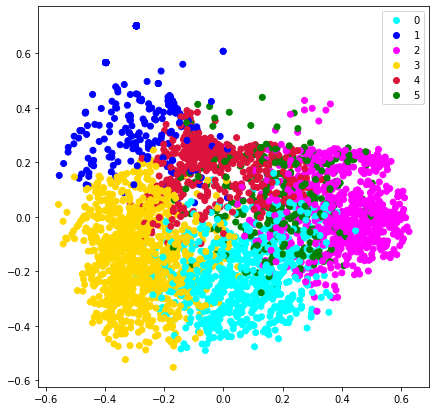

In [74]:
max_label = max(clusters)
max_items = np.random.choice(range(text.shape[0]), size=text.shape[0], replace=False)
    
pca = PCA(n_components=2).fit_transform(text[max_items,:].todense())
#tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(text[max_items,:].todense()))
    
idx = np.random.choice(range(pca.shape[0]), size=text.shape[0], replace=False)
label_sub = clusters[max_items]
label_sub = [2*i for i in label_sub[idx]]

x = pca[idx, 0]
y = pca[idx, 1]
#x = tsne[idx, 0]
#y = tsne[idx, 1]

rcParams['figure.figsize']=[7,7]
classes = list(set(clusters))
values = label_sub
colours = ListedColormap(['aqua','blue','fuchsia','gold','crimson','green'])
scatter = plt.scatter(x, y,c=values,cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig('/home/codonnell/tutors/subj_clust.png')

In [47]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
writing,esol spanish,grammar,english,toefl,spanish esl,spanish,esl,esl esol,esol

Cluster 1
chemistry biology,writing,science,elementary,biology,computer,physics,algebra,spanish,chemistry

Cluster 2
reading elementary,spelling,phonics,math elementary,math,reading,elementary math,elementary 6th,6th,elementary

Cluster 3
act reading,sat writing,writing sat,sat reading,reading act,writing,english,sat,act,reading

Cluster 4
algebra,microsoft excel,excel,computer,microsoft powerpoint,powerpoint,word microsoft,word,microsoft word,microsoft

Cluster 5
math,trigonometry precalculus,prealgebra,geometry,trigonometry,calculus algebra,precalculus,calculus,algebra algebra,algebra

Cluster 6
graphic design,photoshop adobe,adobe illustrator,illustrator,microsoft,design,photography,adobe photoshop,photoshop,adobe

Cluster 7
special,needs,elementary,spectrum,disorder asd,spectrum disorder,asd,autism spectrum,disorder,autism

Cluster 8
proofreading literature,reading,writing reading,grammar e

In [13]:
pd.Series(clusters).value_counts()

4    3091
3    2652
2    2212
1    2014
0     700
dtype: int64

In [65]:
cluster_df = pd.DataFrame({'cluster': clusters, 'hourly_rate': sample['priceRange'].values})
cluster_df.head()

,cluster,hourly_rate
0,1,60.0
1,0,75.0
2,0,95.0
3,3,95.0
4,5,40.0


In [79]:
clus_rates = cluster_df.groupby('cluster')['hourly_rate'].mean()
clus_rates.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64', name='cluster')

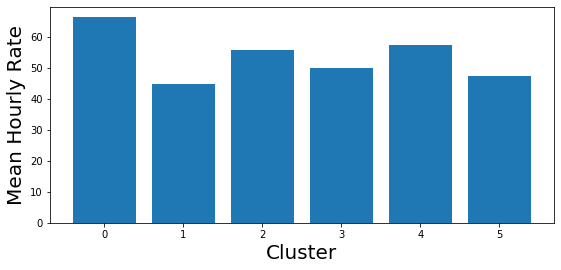

In [88]:
rcParams['figure.figsize']=[7,3]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = clus_rates.index
students = clus_rates.values
ax.bar(langs,students)
plt.xlabel('Cluster',fontsize=20)
plt.ylabel('Mean Hourly Rate',fontsize=20)
plt.savefig('/home/codonnell/tutors/clust_rates.png')

In [68]:
pd.Series(clusters).value_counts()

3    1026
2     742
0     680
4     558
1     313
5     306
dtype: int64

In [60]:
def cluster_var(text):
    
    for i in range(3,30):
        clusters = MiniBatchKMeans(n_clusters=i, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)
        cluster_df = pd.DataFrame({'cluster': clusters, 'hourly_rate': sample['priceRange'].values})
        print(cluster_df.groupby('cluster')['hourly_rate'].mean().to_frame()['hourly_rate'].std())
cluster_var(text)

5.936132112497179
5.653200483107013
7.299108693624601
7.890028711206092
5.628234572447005
5.8515027708776755
8.607905126076583
8.863758193386824
6.810338888222578
6.527061763518383
8.327696593616297
7.086545593292112
8.697218307952316
7.8574795682961875
8.651102843314943
8.892408676932455
10.10491592801804
9.202709239875578
9.880042782799658
9.206815570205809
9.617633231441568
9.375494096481766
10.588239247329186
9.464459678909503
9.073741039708507
10.003126642933116
10.018996838997655


In [56]:
tutor_subjects['tutor_ids']=tutor_subjects['tutor_ids'].apply(float)
tutor_subjects['tutor_ids']=tutor_subjects['tutor_ids'].apply(int)
tut_hours = pd.merge(tutor_subjects, tutor_data, left_on = 'tutor_ids', right_on = 'tut_id')[['subjects','hours_tutoring']]

In [104]:
subj_pop = tut_hours.groupby('subjects').sum().reset_index()
subj_pop['subjects_lower']=subj_pop['subjects'].str.lower()
subj_pop = subj_pop.sort_values(by='hours_tutoring',ascending=False).reset_index()
subj_pop

,index,subjects,hours_tutoring,subjects_lower
0,15,Algebra 1,3083191.0,algebra 1
1,202,Prealgebra,2852249.0,prealgebra
2,16,Algebra 2,2845758.0,algebra 2
3,117,Geometry,2657493.0,geometry
4,220,SAT Math,2618857.0,sat math
...,...,...,...,...
282,132,Hungarian,3531.0,hungarian
283,263,Thai,3520.0,thai
284,128,Harp,3319.0,harp
285,84,Dutch,2756.0,dutch


In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)

In [65]:
labels = tfidf.get_feature_names()
tfidf_df = pd.DataFrame(text.todense()).groupby(clusters).mean().T

In [96]:
cluster_subjects_df = pd.DataFrame()
for clus in range(0,max(clusters)):              
    cluster_subjects_df[clus] = np.array([labels[t] for t in np.argsort(tfidf_df[clus].values)[-50:]])
    
cluster_subjects_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,esol writing,elementary 6th,6th algebra,counseling,probability,prealgebra linear,architecture,esol,grammar esl,chemistry,reading,flute world,act reading
1,proofreading grammar,spss,adhd,college counseling,vocabulary,statistics precalculus,dreamweaver,needs dyslexia,esol english,geometry differential,gmat,flute microsoft,music
2,portuguese,microbiology,spanish,college,spelling,6th,drawing art,science elementary,literature writing,prealgebra linear,accounting statistics,film drawing,proofreading literature
3,6th,sat,phonics elementary,reading public,precalculus prealgebra,elementary 6th,history,homeschool,studies,algebra differential,writing,flute ear,act english
4,elementary 6th,physics chemistry,writing vocabulary,elementary 6th,calculus,physics chemistry,art theory,spelling phonics,sat,math precalculus,algebra algebra,flash study,writing vocabulary
5,reading grammar,chemistry chemistry,reading grammar,6th,study skills,chemistry trigonometry,computer adobe,proofreading,bible,math discrete,powerpoint microsoft,flash spelling,public
6,arabic,geometry,handwriting grammar,toefl,study,engineering,publishing adobe,writing vocabulary,bible studies,prealgebra logic,sat,flash,speaking
7,spelling,calculus,prealgebra elementary,act math,skills,physics calculus,art history,math elementary,french,statistics sat,excel managerial,fitness world,public speaking
8,linguistics,algebra algebra,phonics grammar,act science,statistics,math calculus,film,algebra,vocabulary literature,trigonometry sat,business microsoft,fitness vocabulary,spelling
9,writing reading,html,phonics handwriting,english writing,elementary 6th,trigonometry sat,macintosh adobe,history,spelling,elementary math,quickbooks microsoft,fitness study,writing sat


In [91]:
def subj_rank(subj):
    if subj in subj_pop['subjects_lower'].values:
        return np.where(subj_pop['subjects_lower'].values == subj)[0][0]
    else:
        return 0

In [119]:
most_pop_subjs = []

for i in range(0,max(clusters)):
    
    cluster_subjects_df[str(i) +'_rank'] = cluster_subjects_df[i].apply(subj_rank)
    subj_ranks = cluster_subjects_df[i].apply(subj_rank)
    most_pop_subjs.append([subj_pop['subjects'].iloc[t] for t in np.sort(subj_ranks[subj_ranks!=0])])

In [132]:
most_pop_subjs[12]

['Writing',
 'Grammar',
 'Reading',
 'English',
 'Vocabulary',
 'SAT Reading',
 'Proofreading',
 'SAT Writing',
 'ACT English',
 'Study Skills',
 'ACT Reading',
 'Spelling',
 'Literature',
 'American History',
 'Public Speaking',
 'Social Studies',
 'World History',
 'European History',
 'Geography',
 'Religion',
 'Political Science']